In [1]:
# @title ## 1. Penyiapan Lingkungan dan Instalasi Pustaka
# Pastikan Anda menjalankan sel ini terlebih dahulu di Google Colab.
# Ini akan menginstal semua pustaka yang diperlukan.

!pip install -qU langchain langgraph langchain_community langchain_core faiss-cpu sentence-transformers

print("Instalasi selesai!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.4/438.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

In [10]:
# @title ## 2. Impor Pustaka dan Konfigurasi Awal

import os
import json
from typing import List, TypedDict, Optional, Annotated
from operator import itemgetter

from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver # Untuk menyimpan state jika diperlukan

# --- Konfigurasi API Key Gemini ---
# Menggunakan userdata Colab untuk mengambil API Key
try:
    from google.colab import userdata
    GOOGLE_API_KEY = userdata.get("GOOGLE_AI_STUDIO_API_KEY")
    if GOOGLE_API_KEY is None:
        print("API Key GOOGLE_AI_STUDIO_API_KEY tidak ditemukan di Colab Secrets. Harap tambahkan.")
        # GOOGLE_API_KEY = "" # Atau set default jika ingin mencoba tanpa key (tidak direkomendasikan)
except ImportError:
    # Jika tidak di Colab, Anda bisa set manual atau dari env variable
    GOOGLE_API_KEY = os.environ.get("GOOGLE_AI_STUDIO_API_KEY", "")
    if not GOOGLE_API_KEY:
        print("API Key GOOGLE_AI_STUDIO_API_KEY tidak ditemukan di environment variables.")


# --- Model Embeddings ---
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

# --- Dokumen Contoh sebagai Basis Pengetahuan ---
documents_corpus = [
    Document(page_content="LangGraph adalah pustaka untuk membangun aplikasi LLM stateful dengan mudah.", metadata={"source": "LangGraph Docs Intro"}),
    Document(page_content="LangGraph memungkinkan pembuatan agen, di mana LLM dapat menggunakan alat secara berulang.", metadata={"source": "LangGraph Agents"}),
    Document(page_content="State dalam LangGraph direpresentasikan sebagai TypedDict.", metadata={"source": "LangGraph State"}),
    Document(page_content="Node dalam LangGraph adalah fungsi Python atau objek Runnable. Setiap node memproses state dan mengembalikan update state.", metadata={"source": "LangGraph Nodes Detail"}), # Dokumen kunci untuk pertanyaan tentang 'node'
    Document(page_content="Conditional Edges memungkinkan alur kerja yang dinamis dalam LangGraph, mengarahkan alur berdasarkan kondisi dalam state.", metadata={"source": "LangGraph Edges Detail"}),
    Document(page_content="Ibukota Indonesia adalah Jakarta.", metadata={"source": "Fakta Umum"}),
    Document(page_content="Python adalah bahasa pemrograman yang populer untuk AI.", metadata={"source": "Fakta Python"}),
    Document(page_content="Timnas sepak bola Indonesia baru saja memenangkan pertandingan persahabatan.", metadata={"source": "Berita Olahraga Fiktif"}),
    Document(page_content="Resep membuat nasi goreng sederhana adalah bawang, telur, nasi, dan kecap.", metadata={"source": "Resep Masakan"}),
]

# --- Membuat Vector Store ---
try:
    vector_store = FAISS.from_documents(documents_corpus, embeddings)
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    print("Vector store berhasil dibuat.")
except Exception as e:
    print(f"Error saat membuat vector store: {e}")
    retriever = None

Vector store berhasil dibuat.


In [11]:
# @title ## 3. Mendefinisikan State untuk Graph
# (Sama seperti sebelumnya)
class GraphState(TypedDict):
    original_question: str
    current_question: str
    documents: Optional[List[Document]]
    generation: Optional[str]
    context_relevance: Optional[str]
    iterations: int
    error_message: Optional[str]

In [12]:
# @title ## 4. Fungsi Pembantu untuk Memanggil Gemini API
# (Sama seperti sebelumnya)
async def call_gemini_api(prompt: str, is_json_output: bool = False) -> Optional[str]:
    chat_history = [{"role": "user", "parts": [{"text": prompt}]}]
    payload = {"contents": chat_history}
    api_url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key={GOOGLE_API_KEY}"
    try:
        import httpx
        async with httpx.AsyncClient() as client:
            response = await client.post(api_url, json=payload, timeout=60.0)
            response.raise_for_status()
            result = response.json()
        if (result.get("candidates") and
            result["candidates"][0].get("content") and
            result["candidates"][0]["content"].get("parts") and
            len(result["candidates"][0]["content"]["parts"]) > 0):
            return result["candidates"][0]["content"]["parts"][0]["text"].strip()
        else:
            print(f"Struktur respons tidak sesuai atau konten kosong: {result}")
            return None
    except httpx.HTTPStatusError as e:
        print(f"HTTP error saat memanggil Gemini API: {e.response.status_code} - {e.response.text}")
        return None
    except httpx.RequestError as e:
        print(f"Request error saat memanggil Gemini API: {e}")
        return None
    except Exception as e:
        print(f"Error tidak terduga saat memanggil Gemini API: {e}")
        return None

In [13]:
# @title ## 5. Mendefinisikan Node-node Graph

MAX_ITERATIONS = 3

# --- Node 1: Mengambil Dokumen (Retrieve) ---
# (Sama seperti sebelumnya)
async def retrieve_documents(state: GraphState) -> GraphState:
    print(f"\n🔍 Node: retrieve_documents (Iterasi: {state['iterations']})")
    print(f"   Mencari untuk pertanyaan: '{state['current_question']}'")
    if not retriever:
        print("   ❌ Retriever tidak diinisialisasi. Lewati pengambilan.")
        return {**state, "documents": [], "error_message": "Retriever tidak tersedia."}
    try:
        documents = await retriever.ainvoke(state["current_question"])
        print(f"   📄 Ditemukan {len(documents)} dokumen.")
        return {**state, "documents": documents, "error_message": None}
    except Exception as e:
        print(f"   ❌ Error saat mengambil dokumen: {e}")
        return {**state, "documents": [], "error_message": f"Error retrieval: {str(e)}"}

# --- Node 2: Mengevaluasi Relevansi Dokumen (Grade Documents) ---
# !! PERUBAHAN: Prompt dibuat lebih ketat !!
async def grade_documents(state: GraphState) -> GraphState:
    print("\n🧐 Node: grade_documents")
    question = state["original_question"] # Tetap gunakan pertanyaan original untuk menilai relevansi awal
    documents = state["documents"]
    if not documents:
        print("   ⚠️ Tidak ada dokumen untuk dievaluasi.")
        existing_error = state.get("error_message")
        return {**state, "context_relevance": "no", "error_message": existing_error if existing_error else "Tidak ada dokumen yang diambil untuk dievaluasi."}

    documents_content = "\n\n---\n\n".join([f"Dokumen {i+1}:\n{doc.page_content}" for i, doc in enumerate(documents)])

    prompt = f"""Berikut adalah pertanyaan pengguna dan beberapa dokumen yang diambil.
Tugas Anda adalah menentukan apakah dokumen-dokumen ini secara kolektif mengandung informasi yang **spesifik, substansial, dan langsung relevan** untuk menjawab inti dari pertanyaan pengguna.
Jangan menjawab 'yes' jika dokumen hanya menyentuh topik secara umum atau hanya menyebutkan kata kunci tanpa penjelasan yang memadai terkait pertanyaan.
Jawab HANYA dengan 'yes' atau 'no'.

Pertanyaan: {question}

Dokumen yang Diambil:
{documents_content}

Apakah dokumen-dokumen ini secara spesifik dan substansial relevan untuk menjawab pertanyaan? (yes/no): """

    print("   Mengirim permintaan ke Gemini untuk evaluasi relevansi (dengan prompt lebih ketat)...")
    relevance_output = await call_gemini_api(prompt)
    if relevance_output and relevance_output.lower() in ["yes", "no"]:
        relevance = relevance_output.lower()
        print(f"   ✅ Hasil evaluasi relevansi dari Gemini: {relevance}")
        return {**state, "context_relevance": relevance}
    else:
        print(f"   ❌ Gagal mendapatkan evaluasi relevansi yang valid dari Gemini. Output: {relevance_output}. Mengasumsikan 'no'.")
        return {**state, "context_relevance": "no", "error_message": "Gagal mengevaluasi relevansi dokumen dari LLM."}

# --- Node 3: Memformulasi Ulang Pertanyaan (Transform Query) ---
# (Sama seperti sebelumnya)
async def transform_query(state: GraphState) -> GraphState:
    print("\n🔄 Node: transform_query")
    if state.get("error_message") == "Gagal mengevaluasi relevansi dokumen dari LLM.":
         print(f"   ⚠️ Ada error pada evaluasi relevansi, tidak akan memformulasi ulang.")
         return {**state}
    if state["iterations"] >= MAX_ITERATIONS:
        print(f"   ⚠️ Mencapai batas maksimum iterasi ({MAX_ITERATIONS}). Tidak akan memformulasi ulang.")
        return {**state}

    original_question = state["original_question"]
    documents_content = "\n\n---\n\n".join([f"Dokumen {i+1}:\n{doc.page_content}" for i, doc in enumerate(state.get("documents",[]))])
    prompt = f"""Pertanyaan pengguna sebelumnya adalah: "{original_question}"
Dokumen yang diambil berdasarkan pertanyaan tersebut (atau pertanyaan yang dimodifikasi sebelumnya) ternyata tidak cukup relevan atau kurang spesifik.

Dokumen yang diambil (jika ada):
{documents_content if state.get("documents") else "Tidak ada dokumen yang diambil pada iterasi sebelumnya."}

Tugas Anda:
1. Analisis pertanyaan asli.
2. Jika pertanyaan asli terlalu umum namun mengarah pada suatu topik spesifik (misalnya, "Ceritakan tentang X"), buat pertanyaan yang lebih langsung meminta definisi atau peran X.
3. Jika pertanyaan asli mungkin menggunakan terminologi yang salah, coba perbaiki.
4. Hasilkan SATU pertanyaan baru yang lebih terfokus dan lebih mungkin dijawab dengan informasi spesifik.
5. Jika Anda merasa pertanyaan asli sudah optimal atau tidak bisa diperbaiki, kembalikan pertanyaan asli.

Hanya keluarkan pertanyaan yang telah diformulasi ulang (atau pertanyaan asli jika tidak ada perubahan). Jangan tambahkan penjelasan lain.

Pertanyaan Baru: """
    print("   Mengirim permintaan ke Gemini untuk transformasi query...")
    new_question = await call_gemini_api(prompt)
    if new_question and new_question.strip() and new_question.strip() != original_question:
        print(f"   ✅ Pertanyaan baru dari Gemini: '{new_question}'")
        return {
            **state,
            "current_question": new_question.strip(),
            "iterations": state["iterations"] + 1,
            "documents": None,
            "context_relevance": None,
            "error_message": None
        }
    else:
        print("   ⚠️ Gemini tidak menghasilkan pertanyaan baru yang berbeda atau gagal. Menghentikan transformasi.")
        return {
            **state,
            "iterations": state["iterations"] + 1,
            "error_message": "Gagal memformulasi ulang pertanyaan atau pertanyaan yang dihasilkan LLM sama dengan pertanyaan sebelumnya."
        }

# --- Node 4: Menghasilkan Jawaban (Generate Answer) ---
# !! PERUBAHAN: Prompt lebih direktif untuk menjelaskan istilah kunci !!
async def generate_answer(state: GraphState) -> GraphState:
    print("\n💬 Node: generate_answer")
    current_q = state["current_question"]
    original_q = state["original_question"]
    documents = state["documents"]

    if not documents:
        print("   ⚠️ Tidak ada dokumen yang disediakan untuk menghasilkan jawaban.")
        return {**state, "generation": "Tidak ada informasi yang cukup untuk menjawab pertanyaan.", "error_message": "Tidak ada dokumen untuk generasi jawaban."}

    documents_context = "\n\n---\n\n".join([doc.page_content for doc in documents])

    prompt = f"""Anda adalah asisten AI yang berpengetahuan dan membantu.
Tugas utama Anda adalah menjawab "Pertanyaan Saat Ini" pengguna secara akurat dan ringkas berdasarkan "Konteks Dokumen" yang disediakan.
"Pertanyaan Saat Ini" mungkin merupakan versi yang lebih spesifik atau telah diformulasi ulang dari "Pertanyaan Asli Pengguna". Fokuslah pada "Pertanyaan Saat Ini".

PENTING: Jika "Pertanyaan Saat Ini" meminta penjelasan tentang suatu istilah, konsep, atau komponen spesifik (misalnya, 'node', 'edge', 'state', 'API', dll.), pastikan jawaban Anda secara eksplisit mendefinisikan dan menjelaskan istilah/konsep/komponen tersebut menggunakan informasi yang paling relevan dari "Konteks Dokumen". Prioritaskan penjelasan ini dalam jawaban Anda. Cari definisi atau deskripsi fungsi dari istilah tersebut dalam konteks.

Gunakan HANYA informasi dari "Konteks Dokumen". Jangan gunakan pengetahuan eksternal atau membuat asumsi.
Jika "Konteks Dokumen" tidak menyediakan informasi yang cukup untuk menjawab "Pertanyaan Saat Ini" secara memadai, atau untuk menjelaskan istilah/konsep/komponen spesifik yang ditanyakan, nyatakan dengan jelas bahwa Anda tidak dapat menjawab atau menjelaskan berdasarkan informasi yang diberikan.

Pertanyaan Saat Ini: {current_q}
Pertanyaan Asli Pengguna (sebagai referensi): {original_q}

Konteks Dokumen:
{documents_context}

Jawaban Anda (langsung menjawab Pertanyaan Saat Ini, dan menjelaskan istilah kunci jika ada dalam pertanyaan): """

    print("   Mengirim permintaan ke Gemini untuk generasi jawaban (dengan prompt lebih direktif)...")
    generation = await call_gemini_api(prompt)

    if generation:
        print(f"   ✅ Jawaban dari Gemini: {generation}")
        return {**state, "generation": generation, "error_message": None}
    else:
        print("   ❌ Gagal menghasilkan jawaban dari Gemini.")
        return {**state, "generation": "Maaf, terjadi kesalahan saat mencoba menghasilkan jawaban.", "error_message": "LLM gagal menghasilkan jawaban."}

# --- Node 5: Menangani Kegagalan (Handle No Answer / Error) ---
# (Sama seperti versi perbaikan sebelumnya)
async def handle_no_answer(state: GraphState) -> GraphState:
    print("\n🛑 Node: handle_no_answer")
    determined_cause = state.get("error_message")
    if not determined_cause:
        if state.get("iterations", 0) >= MAX_ITERATIONS and state.get("context_relevance") == "no":
            determined_cause = "Dokumen yang diambil tetap tidak relevan setelah batas maksimum upaya transformasi query tercapai."
        elif state.get("context_relevance") == "no" and not state.get("documents"):
             determined_cause = "Tidak ada dokumen yang dapat diambil atau relevan untuk pertanyaan awal."
        elif state.get("context_relevance") == "no":
            determined_cause = "Dokumen yang diambil dinilai tidak relevan, dan tidak ada upaya transformasi lebih lanjut yang berhasil."
        elif not state.get("documents") and state.get("iterations", 0) == 0 :
             determined_cause = "Tidak ada dokumen yang dapat diambil untuk pertanyaan awal."
        elif not state.get("documents") and state.get("iterations", 0) > 0:
             determined_cause = "Gagal mengambil dokumen yang relevan setelah transformasi query."
        else:
            determined_cause = "Tidak dapat menemukan jawaban yang relevan atau terjadi kesalahan yang tidak spesifik dalam proses."
    final_message = f"Maaf, saya tidak dapat menjawab pertanyaan Anda saat ini. Penyebab: {determined_cause}"
    print(f"   Pesan akhir: {final_message}")
    return {**state, "generation": final_message, "error_message": determined_cause}

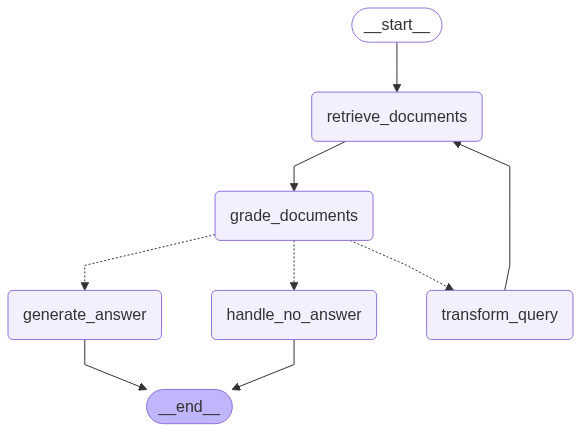

In [14]:
# @title ## 6. Mendefinisikan Edge (Alur Logika) dan Membuat Graph
from IPython.display import display, Image

def decide_next_step(state: GraphState):
    print("\n🚦 Node Keputusan: decide_next_step")
    context_relevance = state.get("context_relevance")
    iterations = state["iterations"]
    current_error = state.get("error_message")
    if current_error:
        if "Retriever tidak tersedia" in current_error or \
           "Gagal mengevaluasi relevansi dokumen dari LLM" in current_error or \
           "Gagal memformulasi ulang pertanyaan" in current_error:
            print(f"   Keputusan: Ditemukan error kritis '{current_error}', menuju handle_no_answer.")
            return "handle_no_answer"
    if context_relevance == "yes":
        print("   Keputusan: Dokumen relevan, menuju generate_answer.")
        return "generate_answer"
    else:
        if iterations < MAX_ITERATIONS:
            print(f"   Keputusan: Dokumen tidak relevan atau belum dievaluasi, iterasi {iterations} < {MAX_ITERATIONS}. Menuju transform_query.")
            return "transform_query"
        else:
            print(f"   Keputusan: Dokumen tidak relevan dan mencapai batas iterasi ({iterations}). Menuju handle_no_answer.")
            return "handle_no_answer"

workflow = StateGraph(GraphState)
workflow.add_node("retrieve_documents", retrieve_documents)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("handle_no_answer", handle_no_answer)
workflow.add_edge(START, "retrieve_documents")
workflow.add_edge("retrieve_documents", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_next_step,
    {
        "generate_answer": "generate_answer",
        "transform_query": "transform_query",
        "handle_no_answer": "handle_no_answer"
    }
)
workflow.add_edge("transform_query", "retrieve_documents")
workflow.add_edge("generate_answer", END)
workflow.add_edge("handle_no_answer", END)
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
# @title ## 7. Menjalankan Graph dengan Pertanyaan Contoh
# (Sama seperti sebelumnya)
import asyncio
async def run_graph(question: str):
    if not retriever:
        print("❌ Tidak dapat menjalankan graph karena retriever gagal diinisialisasi.")
        return
    initial_state = {
        "original_question": question,
        "current_question": question,
        "iterations": 0,
        "error_message": None,
        "documents": None,
        "generation": None,
        "context_relevance": None
    }
    print(f"\n🚀 Memulai eksekusi graph untuk pertanyaan: '{question}'")
    final_state = await app.ainvoke(initial_state)
    print("\n--- Hasil Akhir ---")
    print(f"Pertanyaan Asli: {final_state.get('original_question')}")
    if final_state.get('current_question') != final_state.get('original_question'):
        print(f"Pertanyaan Terakhir Digunakan: {final_state.get('current_question')}")
    print(f"Jawaban yang Dihasilkan: {final_state.get('generation')}")
    print(f"Jumlah Iterasi: {final_state.get('iterations')}")
    final_error_message = final_state.get('error_message')
    if final_error_message and "Maaf, saya tidak dapat menjawab" not in final_state.get('generation',''):
         print(f"Pesan Error Internal (jika ada): {final_error_message}")

# @title ## Jalankan Pertanyaan Anda Sendiri
# (Sama seperti sebelumnya)
import asyncio
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("nest_asyncio berhasil diterapkan.")
except ImportError:
    print("Pustaka nest_asyncio tidak ditemukan. Menginstal...")
    !pip install -q nest_asyncio
    import nest_asyncio
    nest_asyncio.apply()
    print("nest_asyncio berhasil diinstal dan diterapkan.")
except RuntimeError as e:
    if "cannot apply nest_asyncio" in str(e).lower():
        print(f"nest_asyncio sudah diterapkan atau tidak dapat diterapkan lagi: {e}")
    else:
        raise e

# --- Uji coba pertanyaan yang sebelumnya bermasalah atau untuk melihat perbaikan ---
my_question = "Ceritakan tentang node di LangGraph."
# my_question = "Berapa harga saham Google hari ini?"
# my_question = "Apa fungsi utama dari conditional edges dalam LangGraph?"

asyncio.run(run_graph(my_question))

print("\n--- Selesai ---")

nest_asyncio berhasil diterapkan.

🚀 Memulai eksekusi graph untuk pertanyaan: 'Ceritakan tentang node di LangGraph.'

🔍 Node: retrieve_documents (Iterasi: 0)
   Mencari untuk pertanyaan: 'Ceritakan tentang node di LangGraph.'
   📄 Ditemukan 3 dokumen.

🧐 Node: grade_documents
   Mengirim permintaan ke Gemini untuk evaluasi relevansi (dengan prompt lebih ketat)...
   ✅ Hasil evaluasi relevansi dari Gemini: no

🚦 Node Keputusan: decide_next_step
   Keputusan: Dokumen tidak relevan atau belum dievaluasi, iterasi 0 < 3. Menuju transform_query.

🔄 Node: transform_query
   Mengirim permintaan ke Gemini untuk transformasi query...
   ✅ Pertanyaan baru dari Gemini: 'Apa peran node dalam LangGraph dan bagaimana node terhubung satu sama lain untuk membentuk graf?'

🔍 Node: retrieve_documents (Iterasi: 1)
   Mencari untuk pertanyaan: 'Apa peran node dalam LangGraph dan bagaimana node terhubung satu sama lain untuk membentuk graf?'
   📄 Ditemukan 3 dokumen.

🧐 Node: grade_documents
   Mengirim per